# Trial Feature Price

In [1]:
# For Analysis
import numpy as np
import pandas as pd

# For Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For Calculations
from math import floor

#For Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression , Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

# For Validation
from sklearn.metrics import mean_squared_error, accuracy_score

# For Storing Models
import pickle
%matplotlib inline

# For Warnings
import warnings
warnings.filterwarnings("ignore")

- Dataset mencakup listings, reviews, dan calendar. Dataset ini memberikan gambaran lengkap tentang listing Airbnb di Seattle. Dalam analisis ini, dataset listings yang digunakan.
Setiap catatan merupakan listing unik dan berisi informasi tentang listing tersebut.
- Tujuan analisis adalah memprediksi harga optimal per malam untuk listing baru dan memberikan rekomendasi kepada host. Oleh karena itu, harga per malam menjadi variabel target, yang merupakan variabel kontinu dan membutuhkan teknik regresi.

- Terdapat banyak fitur yang memberikan informasi tentang host, properti, lokasi, dan ulasan. Semua fitur yang berkaitan dengan host untuk listing yang ada tidak dapat digunakan dalam model karena tidak diketahui untuk host baru.
Fitur yang berkaitan dengan properti dan lokasi dapat digunakan dalam model. Karena fitur lokasi sulit untuk dikuantifikasi, skor lingkungan (Neighborhood score) ditambahkan ke dataset (akan dibahas kemudian) dan digunakan dalam model.
Seorang host baru belum memiliki ulasan, sehingga fitur yang berkaitan dengan ulasan tidak dapat digunakan dalam model.

In [5]:
#Pembacaan data
listings = pd.read_csv('/content/listings.csv')
calendar = pd.read_csv('/content/calendar.csv')
reviews = pd.read_csv('/content/reviews.csv')

In [6]:
#mendapatkan gambaran kecil dari data tersebut
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [7]:
#Periksa informasi lapangan
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [8]:
#Periksa distribusi statistik untuk kolom Numerik
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [9]:
#Periksa distribusi kolom Kategorikal dan Teks
listings.describe(include=["O"])

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,...,has_availability,calendar_last_scraped,first_review,last_review,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
count,3818,3818,3818,3641,3249,3818,3818,2786,2212,2884,...,3818,3818,3191,3191,3818,3818,3818,3818,3818,3818
unique,3818,1,3792,3478,3119,3742,1,2506,1999,2574,...,1,1,984,321,1,1,2,3,2,2
top,https://www.airbnb.com/rooms/241032,2016-01-04,Capitol Hill Apartment,This is a modern fully-furnished studio apartm...,"*Note: This fall, there will be major renovati...",Our space is a mix of a hostel and a home. We ...,none,Wallingford is a mostly-residential neighborho...,All of our rentals are fully licensed and regu...,Convenient public transportation. The location...,...,t,2016-01-04,2015-09-21,2016-01-02,f,WASHINGTON,f,strict,f,f
freq,1,3818,3,15,14,10,3818,17,39,32,...,3818,3818,25,94,3818,3818,3227,1417,3497,3443


In [10]:
#Listing columns
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [11]:
#Periksa level beberapa fitur penting terkait daftar
cat_level=['property_type','room_type','bed_type','cancellation_policy']
[listings[c].value_counts() for c in cat_level]

[property_type
 House              1733
 Apartment          1708
 Townhouse           118
 Condominium          91
 Loft                 40
 Bed & Breakfast      37
 Other                22
 Cabin                21
 Camper/RV            13
 Bungalow             13
 Boat                  8
 Tent                  5
 Treehouse             3
 Dorm                  2
 Chalet                2
 Yurt                  1
 Name: count, dtype: int64,
 room_type
 Entire home/apt    2541
 Private room       1160
 Shared room         117
 Name: count, dtype: int64,
 bed_type
 Real Bed         3657
 Futon              74
 Pull-out Sofa      47
 Airbed             27
 Couch              13
 Name: count, dtype: int64,
 cancellation_policy
 strict      1417
 moderate    1251
 flexible    1150
 Name: count, dtype: int64]

Pengamatan EDA

- Harga (price), yang merupakan variabel target, memiliki distribusi miring ke kanan dengan median = 100 dan rata-rata = 128.
- House dan Apartment adalah jenis properti yang paling populer. Semua jenis properti dengan jumlah kurang dari 1% dari total digabungkan ke dalam kategori "Others".
- Entire room/apartment adalah jenis kamar yang paling populer, terdapat di 66% listing.
- Terdapat total 87 lingkungan (neighborhoods) di Seattle. Belltown dan Broadway adalah lingkungan yang paling populer berdasarkan jumlah listing Airbnb.
- Setiap properti memiliki rata-rata 1,3 kamar tidur, 1,25 kamar mandi, dan dapat menampung rata-rata 3,3 tamu.
- Terdapat total 42 fasilitas (amenities) unik yang ditawarkan di berbagai listing, dan tidak ada korelasi di antara kelompok fasilitas tersebut.

In [29]:
#Fungsi untuk menampilkan kolom dengan nilai yang hilang
def show_missing_values(df):
    missing_vals = df.isnull().sum().sort_values(ascending = False)

    return missing_vals.iloc[missing_vals.nonzero()[0]]

In [32]:
show_missing_values(listings)

,0
license,3818
square_feet,3721
monthly_price,2301
security_deposit,1952
weekly_price,1809
notes,1606
neighborhood_overview,1032
cleaning_fee,1030
transit,934
host_about,859


In [33]:
#Fungsi untuk menangani nilai yang hilang
def handle_missing_remove(df):
    temp_df=df.copy()
    #Isikan 0 sebagai pengganti catatan yang hilang untuk jumlah kamar tidur, kamar mandi, tempat tidur
    temp_df.beds.fillna(0,inplace=True)
    temp_df.bedrooms.fillna(0,inplace=True)
    temp_df.bathrooms.fillna(0,inplace=True)

    #Hapus kolom lisensi dan kaki persegi yang memiliki lebih dari 95% nilai hilang
    temp_df.drop(['license','square_feet'],axis=1,inplace=True)

    return temp_df

Ada banyak bidang yang hanya memiliki satu tingkat dan tidak berguna untuk analisis. Daripada menghilangkan kolom-kolom ini, hanya subkumpulan kolom yang dipertimbangkan untuk menghitung harga optimal.

In [34]:
listings=handle_missing_remove(listings)
show_missing_values(listings)

,0
monthly_price,2301
security_deposit,1952
weekly_price,1809
notes,1606
neighborhood_overview,1032
cleaning_fee,1030
transit,934
host_about,859
host_acceptance_rate,773
review_scores_accuracy,658


Berfungsi untuk melakukan praproses fitur

In [36]:
def preprocess(df):

    temp_df = df.copy()
    temp_df = temp_df.replace(
            {
            'host_has_profile_pic': {'t': True, 'f': False},
            'host_identity_verified': {'t': True, 'f': False},
            'instant_bookable': {'t': True, 'f': False},
            }
    )

    ## Kode ulang property_type
    def recode_prop(value):
        if value not in ['House', 'Apartment','Condominium','Townhouse','Loft']:
            return 'other_prop_type'
        return value

    temp_df['property_type'] = temp_df['property_type'].apply(recode_prop)

    ## Kode ulang bed_type
    def recode_bed(value):
        if value not in ['Real Bed']:
            return 'other_bed_type'
        return value

    temp_df['bed_type'] = temp_df['bed_type'].apply(recode_bed)

    #Hitung pembagian kamar tidur dan kamar mandi per orang. Semakin tinggi porsinya, semakin banyak kenyamanannya.
    temp_df = temp_df.assign(
        bedroom_share = temp_df.bedrooms/temp_df.accommodates,
        bathroom_share = temp_df.bathrooms/temp_df.accommodates,

    )

    df=temp_df
    print("Pre-processing completed...")
    return df

In [38]:
#Proses awal data listingan
listings=preprocess(listings)

Pre-processing completed...


In [39]:
#Buat kolom tiruan dengan pengkodean one-hot
def create_dummies(df, columns = ['room_type', 'property_type', 'bed_type', 'cancellation_policy']):
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix = column)
        df = pd.concat([df,dummies], axis = 1)
    return df

In [40]:
# Buat kolom tiruan yang diperlukan
listings = create_dummies(listings)

Preprocess amenities

In [41]:
#Kosongkan nilai yang hilang di kolom Fasilitas
listings.loc[listings['amenities'] == '{}','amenities'] = ""

In [42]:
#Hapus simbol dan pisahkan fasilitasnya dengan | sebagai pemisah
listings['amenities'] = listings['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")]))

In [43]:
listings['amenities'].head()

,amenities
0,TV|Cable TV|Internet|Wireless Internet|Air Con...
1,TV|Internet|Wireless Internet|Kitchen|Free Par...
2,TV|Cable TV|Internet|Wireless Internet|Air Con...
3,Internet|Wireless Internet|Kitchen|Indoor Fire...
4,TV|Cable TV|Internet|Wireless Internet|Kitchen...


In [44]:
#Ambil daftar fasilitas unik di semua tempat
amenities = np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split("|")).values))
amenities

array(['', '24-Hour Check-in', 'Air Conditioning', 'Breakfast',
       'Buzzer/Wireless Intercom', 'Cable TV', 'Carbon Monoxide Detector',
       'Cat(s)', 'Dog(s)', 'Doorman', 'Dryer', 'Elevator in Building',
       'Essentials', 'Family/Kid Friendly', 'Fire Extinguisher',
       'First Aid Kit', 'Free Parking on Premises', 'Gym', 'Hair Dryer',
       'Hangers', 'Heating', 'Hot Tub', 'Indoor Fireplace', 'Internet',
       'Iron', 'Kitchen', 'Laptop Friendly Workspace',
       'Lock on Bedroom Door', 'Other pet(s)', 'Pets Allowed',
       'Pets live on this property', 'Pool', 'Safety Card', 'Shampoo',
       'Smoke Detector', 'Smoking Allowed', 'Suitable for Events', 'TV',
       'Washer', 'Washer / Dryer', 'Wheelchair Accessible',
       'Wireless Internet'], dtype='<U26')

In [45]:
#Petakan ada atau tidaknya fasilitas untuk setiap listing
amenities_matrix = np.array([listings['amenities'].map(lambda amns: amn in amns).values for amn in amenities])
amenities_matrix

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [ True, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True]])

In [46]:
#Buat kerangka data fasilitas dengan nilai boolean
amen=pd.DataFrame(data=amenities_matrix.T, columns=amenities)
amen.head()

,,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,...,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
0,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
1,True,False,False,False,True,False,True,False,False,False,...,True,False,True,False,False,True,True,False,False,True
2,True,False,True,False,False,True,True,True,True,False,...,False,True,True,False,False,True,True,False,False,True
3,True,False,False,False,False,False,True,False,False,False,...,True,True,True,False,False,False,True,False,False,True
4,True,False,False,False,False,True,True,False,False,False,...,False,True,True,False,False,True,False,False,False,True


In [47]:
#Gabungkan id daftar ke kerangka data amin
listings_amenities = pd.concat([amen,listings['id']], axis=1)
listings_amenities.head()

,,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,...,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet,id
0,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,True,True,False,False,True,241032
1,True,False,False,False,True,False,True,False,False,False,...,False,True,False,False,True,True,False,False,True,953595
2,True,False,True,False,False,True,True,True,True,False,...,True,True,False,False,True,True,False,False,True,3308979
3,True,False,False,False,False,False,True,False,False,False,...,True,True,False,False,False,True,False,False,True,7421966
4,True,False,False,False,False,True,True,False,False,False,...,True,True,False,False,True,False,False,False,True,278830


In [48]:
#Hapus kolom pertama dari listing_amenities yang namanya ""
listings_amenities=listings_amenities.drop("",axis=1)
listings_amenities.head()

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,Dryer,...,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet,id
0,False,True,False,False,True,False,False,False,False,True,...,False,False,False,False,True,True,False,False,True,241032
1,False,False,False,True,False,True,False,False,False,True,...,False,True,False,False,True,True,False,False,True,953595
2,False,True,False,False,True,True,True,True,False,True,...,True,True,False,False,True,True,False,False,True,3308979
3,False,False,False,False,False,True,False,False,False,True,...,True,True,False,False,False,True,False,False,True,7421966
4,False,False,False,False,True,True,False,False,False,False,...,True,True,False,False,True,False,False,False,True,278830


In [49]:
listings_amenities.columns

Index(['24-Hour Check-in', 'Air Conditioning', 'Breakfast',
       'Buzzer/Wireless Intercom', 'Cable TV', 'Carbon Monoxide Detector',
       'Cat(s)', 'Dog(s)', 'Doorman', 'Dryer', 'Elevator in Building',
       'Essentials', 'Family/Kid Friendly', 'Fire Extinguisher',
       'First Aid Kit', 'Free Parking on Premises', 'Gym', 'Hair Dryer',
       'Hangers', 'Heating', 'Hot Tub', 'Indoor Fireplace', 'Internet', 'Iron',
       'Kitchen', 'Laptop Friendly Workspace', 'Lock on Bedroom Door',
       'Other pet(s)', 'Pets Allowed', 'Pets live on this property', 'Pool',
       'Safety Card', 'Shampoo', 'Smoke Detector', 'Smoking Allowed',
       'Suitable for Events', 'TV', 'Washer', 'Washer / Dryer',
       'Wheelchair Accessible', 'Wireless Internet', 'id'],
      dtype='object')

Mengkategorikan fasilitas ke dalam kelompok yang bermakna dengan membuat kamus

In [50]:
amenity_recode={
                'Air Conditioning':'Weather Control',
                'Indoor Fireplace':'Weather Control',
                'Heating':'Weather Control',

                'Carbon Monoxide Detector':'Safety Features',
                'Fire Extinguisher':'Safety Features',
                'First Aid Kit':'Safety Features',
                'Smoke Detector':'Safety Features',

                'Buzzer/Wireless Intercom':'Security Features',
                'Doorman':'Security Features',
                'Safety Card':'Security Features',
                'Lock on Bedroom Door':'Security Features',

                'Cat(s)':'Pet Friendly',
                'Dog(s)':'Pet Friendly',
                'Pets Allowed':'Pet Friendly',
                'Pets live on this property':'Pet Friendly',
                'Other pet(s)':'Pet Friendly',

                'Elevator in Building':'Access Friendly',
                'Wheelchair Accessible':'Access Friendly',

                'Essentials':'Essentials',
                'Hair Dryer':'Essentials',
                'Hangers':'Essentials',
                'Iron':'Essentials',
                'Shampoo':'Essentials',

                'Cable TV':'TV',
                'TV':'TV',

                'Internet':'Internet',
                'Wireless Internet':'Internet',
                'Laptop Friendly Workspace':'Internet',

                'Dryer':'Laundry Facility',
                'Washer':'Laundry Facility',
                'Washer / Dryer':'Laundry Facility',

                #Leaving amenities as such which cannot be grouped
                #'Kitchen',
                #'Family/Kid Friendly',
                #'Free Parking on Premises',
                #'Breakfast',
                #'24-Hour Check-in',
                #'Hot Tub',
                #'Pool',
                #'Gym',
                #'Smoking Allowed',
                #'Suitable for Events'
}

In [51]:
#Mencairkan kerangka data fasilitas dan kode ulang dari kamus
listings_amenities_melt = listings_amenities.melt(id_vars=['id'], var_name='amenity')

#Pengodean ulang dan memasukkan kolom baru bernama amenity_modified
listings_amenities_melt = listings_amenities_melt.assign(
    amenity_modified = listings_amenities_melt.amenity.replace(amenity_recode)
)

listings_amenities_melt.head()

,id,amenity,value,amenity_modified
0,241032,24-Hour Check-in,False,24-Hour Check-in
1,953595,24-Hour Check-in,False,24-Hour Check-in
2,3308979,24-Hour Check-in,False,24-Hour Check-in
3,7421966,24-Hour Check-in,False,24-Hour Check-in
4,278830,24-Hour Check-in,False,24-Hour Check-in


In [52]:
#Pivot kerangka data yang dilelehkan sebelum digabungkan dengan kerangka data asli
listings_amenities_pivot = listings_amenities_melt.pivot_table(
    index='id',
    columns='amenity_modified',
    values='value',
    aggfunc='max'
)

listings_amenities_pivot.head()

amenity_modified,24-Hour Check-in,Access Friendly,Breakfast,Essentials,Family/Kid Friendly,Free Parking on Premises,Gym,Hot Tub,Internet,Kitchen,Laundry Facility,Pet Friendly,Pool,Safety Features,Security Features,Smoking Allowed,Suitable for Events,TV,Weather Control
id,,,,,,,,,,,,,,,,,,,
3335,False,False,False,False,True,True,False,False,True,True,True,True,False,True,False,False,False,False,True
4291,False,False,False,True,False,True,False,False,True,False,True,False,False,True,False,False,False,True,True
5682,True,False,False,True,False,False,False,False,True,True,True,False,False,True,False,False,False,True,True
6606,False,False,False,True,False,True,False,True,True,True,False,True,False,False,False,False,False,True,True
7369,False,True,False,True,False,False,False,False,True,True,True,False,False,True,False,False,False,True,True


In [53]:
#Penggabungan dengan kerangka data fasilitas kembali ke kerangka data listingan asli
listings_joined=listings.join(listings_amenities_pivot,on="id",how="inner")
listings_joined.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,Kitchen,Laundry Facility,Pet Friendly,Pool,Safety Features,Security Features,Smoking Allowed,Suitable for Events,TV,Weather Control
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,True,True,False,False,False,False,False,False,True,True
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,True,True,False,False,True,True,False,False,True,True
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,True,True,True,False,True,False,False,False,True,True
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,True,True,False,False,True,True,False,False,False,True
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,True,False,False,False,True,False,False,False,True,True


<Axes: >

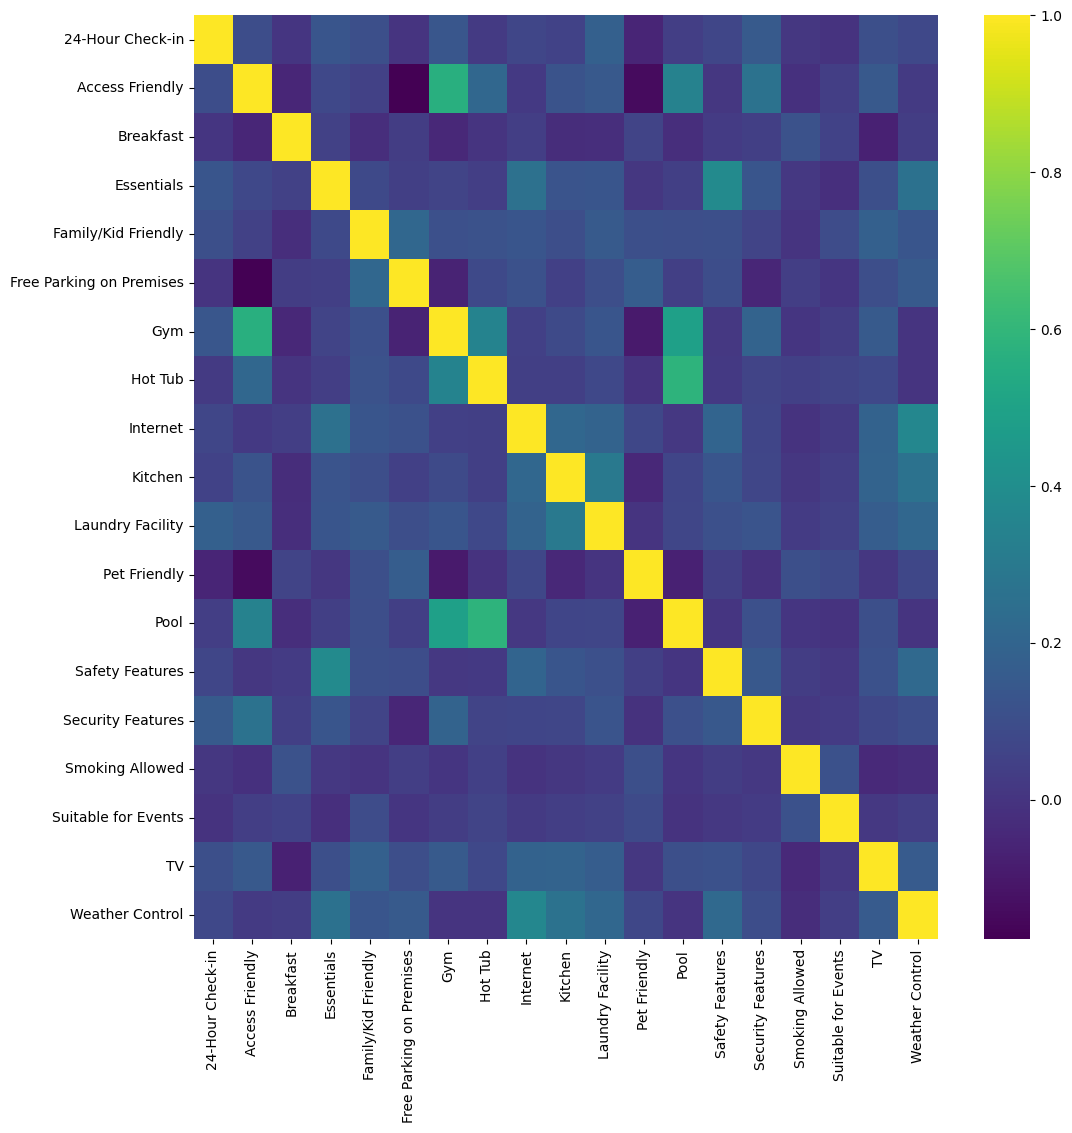

In [54]:
# Menghasilkan Heatmap viridis untuk memeriksa korelasi antar fasilitas
listings_selected_amenities=listings_joined[['24-Hour Check-in', 'Access Friendly', 'Breakfast', 'Essentials',
       'Family/Kid Friendly', 'Free Parking on Premises', 'Gym', 'Hot Tub',
       'Internet', 'Kitchen', 'Laundry Facility', 'Pet Friendly', 'Pool',
       'Safety Features', 'Security Features', 'Smoking Allowed',
       'Suitable for Events', 'TV', 'Weather Control']]
fig = plt.figure(figsize= (12,12))
sns.heatmap(listings_selected_amenities.corr(), annot=False, vmax=1, cmap='viridis', square=False)

Terlihat bahwa tidak ada 2 fasilitas yang mempunyai korelasi tinggi diantara keduanya.